In [261]:
import numpy as np
import matplotlib.pyplot as plt
import gym
from tqdm import tqdm
from mpl_toolkits import mplot3d
import math
from scipy.stats import poisson
import time

In [126]:
MAX_CARS = 20
MAX_MOVE_OF_CARS = 5
EXPECTED_FIRST_LOC_REQUESTS = 3
EXPECTED_SECOND_LOC_REQUESTS = 4
EXPECTED_FIRST_LOC_RETURNS = 3
EXPECTED_SECOND_LOC_RETURNS = 2
DISCOUNT_FACTOR = 0.9
RENTAL_CREDIT = 10
COST_OF_MOVING = -2
POISSON_UPPER_BOUND = 11

In [208]:
policy = np.zeros((MAX_CARS + 1, MAX_CARS + 1))
stateVal = np.zeros((MAX_CARS + 1, MAX_CARS + 1))
states = [(i, j) for i in range(MAX_CARS + 1) for j in range(MAX_CARS + 1)]
actions = np.arange(-MAX_MOVE_OF_CARS, MAX_MOVE_OF_CARS + 1)
Pcache = np.array([[poisson.pmf(j, i) for i in range(6)] for j in range(22)])

In [216]:
def value(state, action, values):
    v = 0
    state = (state[0] + action, state[1] - action)
    max_return_0 = int(MAX_CARS - state[0])
    max_return_1 = int(MAX_CARS - state[1])
    for return0 in range(min(max_return_0, POISSON_UPPER_BOUND)):
        for return1 in range(min(max_return_1, POISSON_UPPER_BOUND)):
            max_rent0 = int(state[0] + return0)
            max_rent1 = int(state[1] + return1)
            for rent0 in range(min(max_rent0, POISSON_UPPER_BOUND)):
                for rent1 in range(min(max_rent1, POISSON_UPPER_BOUND)):
                    p = Pcache[(rent0, EXPECTED_FIRST_LOC_REQUESTS)] *\
                        Pcache[(rent1, EXPECTED_SECOND_LOC_REQUESTS)] *\
                        Pcache[(return0, EXPECTED_FIRST_LOC_RETURNS)] *\
                        Pcache[(return1, EXPECTED_SECOND_LOC_RETURNS)]
                    r = action * COST_OF_MOVING +\
                        (return0 + return1) * RENTAL_CREDIT
                    state_prime = (int(state[0] + return0 - rent0), int(state[1] + return1 - rent1))
                    v += p * (r + DISCOUNT_FACTOR * values[(state_prime[0], state_prime[1])])
    return v

In [264]:
def policy_eval(policy, theta=0.00001):
    newValues = np.zeros((MAX_CARS + 1, MAX_CARS + 1))
    while True:
        prev = newValues.copy()
        for state in states:
            newValues[state] = value(state, policy[state], newValues)
        print((abs(prev - newValues).flatten()).sum())
        if(max(abs(prev - newValues).flatten()) < theta):
            break
    return newValues

In [265]:
def policy_improvement(values):
    policy = np.zeros((MAX_CARS + 1, MAX_CARS + 1))
    for state in states:
        q_values = [value(state, action, values) for action in actions]
        policy[state] = actions[np.argmax(q_values)]
    return policy

In [268]:
def runnnn():
    policy = np.zeros((MAX_CARS + 1, MAX_CARS + 1))
    for i in tqdm(range(3)):
        values = policy_eval(policy)
        print(i, 'values are updated')
        new_policy = policy_improvement(values)
        print(i, 'policy is updated')
        plot_policy(new_policy)
        print(abs(new_policy - policy).sum())
        if abs(new_policy - policy).sum() == 0: return new_policy
        policy = new_policy

  0%|          | 0/3 [00:00<?, ?it/s]

17476.38884972004
8642.270314733256
4076.2130713988136
1809.8867243491623
759.7886327036966
303.9955518824057
116.90593471823468
43.56020958195461
15.841010186614593
5.657229937353088
1.9939284507855843
0.6962160513981019
0.2414979914288206
0.08338367527324819
0.02869819524961248
0.00985505484080429
0.003379014970824934
0.0011573194588415658
0.0003960875568054245
0 values are updated
0 policy is updated


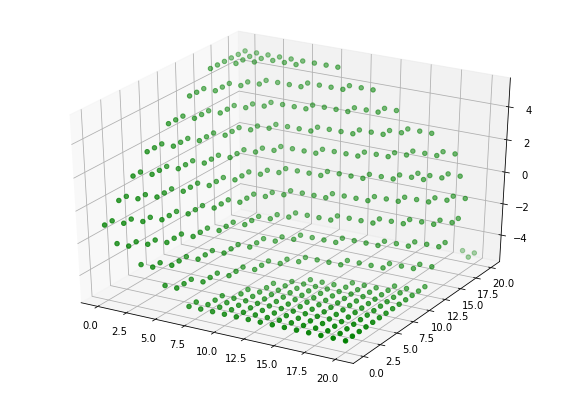

 33%|███▎      | 1/3 [05:38<11:16, 338.29s/it]

1350.0
37606.28418683263
20559.11257360138
11473.916191910677
6149.823292872328
3249.553227404893
1703.1597287866352
887.6654370891208
460.8182883411091
238.5657443015847
123.26610920616271
63.6045323204051
32.78818337341618
16.890986865846088
8.697364879569086
4.476887469201991
2.303897897639037
1.1854381291849863
0.6098798804299901
0.31374321678199457
0.16139106055246077
0.0830170060100952
0.0427014189642575
0.021963869209252862
0.011297159615663466
0.005810658659896828
0.0029886732521545722
0.0015371964222408163
1 values are updated
1 policy is updated


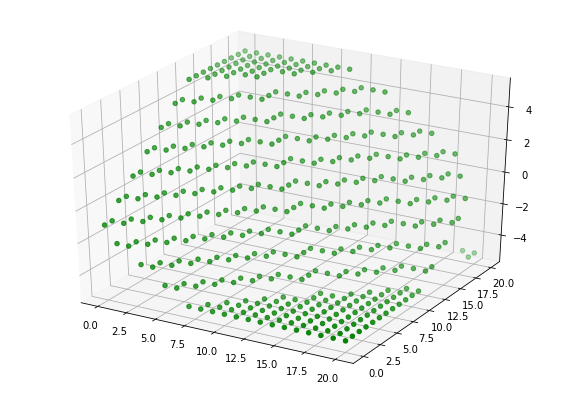

 67%|██████▋   | 2/3 [14:17<06:32, 392.51s/it]

318.0
34792.3470850288
22585.262324716343
13632.617503496476
7534.45175002442
4086.0449281757683
2197.144162146837
1174.7980468596334
625.6775706482924
332.29576127126205
176.13225075333003
93.22695210045109
49.29563627481905
26.047417024353592
13.75621127988795
7.262301727991675
3.832976816664874
2.02263179119894
1.0671839427206877
0.5630151325358479
0.2970099571371799
0.15667531298703952
0.08264466355433797
0.04359313350895466
0.02299394536345223
0.012128393282870076
0.006397186448408143
0.0033742079522359747
0.0017797238622094813
0.0009387110012237798
2 values are updated
2 policy is updated


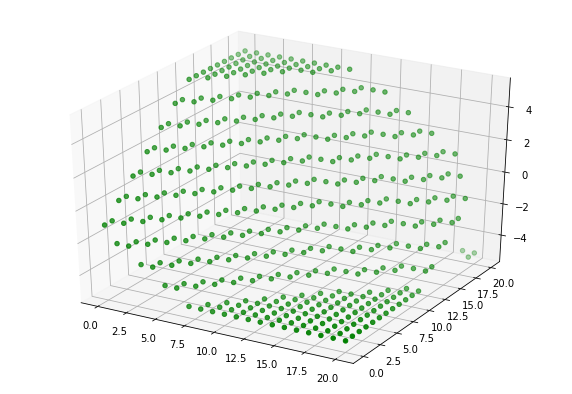

100%|██████████| 3/3 [24:15<00:00, 485.22s/it]

20.0


In [269]:
runnnn()

In [255]:
def plot_policy(policy):
    x = []
    y = []
    z = []
    for i in range(MAX_CARS + 1):
        for j in range(MAX_CARS + 1):
            x.append(i)
            y.append(j)
            z.append(policy[(i, j)])
    fig = plt.figure(figsize = (10, 7))
    ax = plt.axes(projection ="3d")
    ax.scatter3D(x, y, z, color = "green")
    return plt.show()

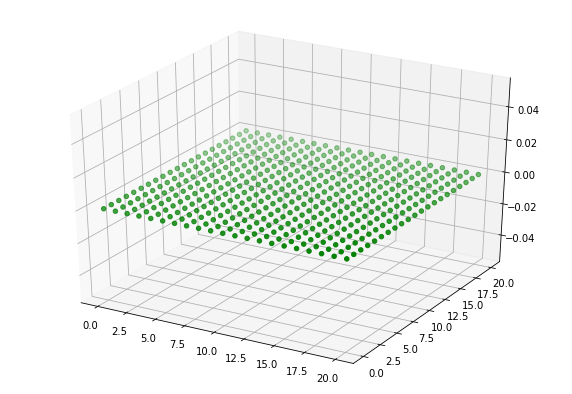

In [256]:
plot_policy(policy)